1. Title & Introduction

# Disease Diagnosis Prediction using Machine Learning
**Author:** Jagadeep Mamidi  
**Date:** 2025-09-26

This notebook addresses disease diagnosis prediction with advanced ML workflow: preprocessing, feature engineering, EDA, model building, hyperparameter tuning, and interpretability.


2. Setup & Data Loading

In [48]:
# Install required packages
!pip install seaborn imbalanced-learn shap --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

# File upload in Colab
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('disease_diagnosis.csv')

Saving disease_diagnosis.csv to disease_diagnosis (3).csv


3. Data Overview & Cleaning

In [49]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Patient_ID           2000 non-null   int64  
 1   Age                  2000 non-null   int64  
 2   Gender               2000 non-null   object 
 3   Symptom_1            2000 non-null   object 
 4   Symptom_2            2000 non-null   object 
 5   Symptom_3            2000 non-null   object 
 6   Heart_Rate_bpm       2000 non-null   int64  
 7   Body_Temperature_C   2000 non-null   float64
 8   Blood_Pressure_mmHg  2000 non-null   object 
 9   Oxygen_Saturation_%  2000 non-null   int64  
 10  Diagnosis            2000 non-null   object 
 11  Severity             2000 non-null   object 
 12  Treatment_Plan       2000 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 203.3+ KB
None
        Patient_ID          Age  Heart_Rate_bpm  Body_Temperature_C  \
cou

In [50]:
# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

4. Feature Engineering: Symptoms & Severity

In [52]:
# Combine Respiratory Symptoms
respiratory_terms = ['shortness of breath', 'cough']
df['Respiratory_Symptom'] = df[['Symptom_1','Symptom_2','Symptom_3']].apply(
    lambda x: int(any(term in x.values for term in respiratory_terms)), axis=1)

# Encoding categorical variables
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Standardize numeric features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

5. Class Balance Visualization

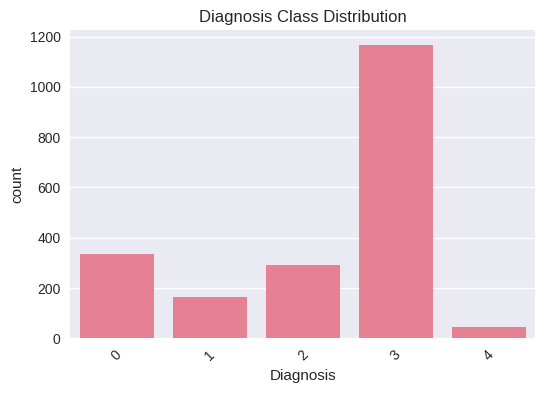

In [53]:
plt.figure(figsize=(6,4))
sns.countplot(x='Diagnosis', data=df)
plt.xticks(rotation=45)
plt.title('Diagnosis Class Distribution')
plt.show()

6. EDA & Visualizations

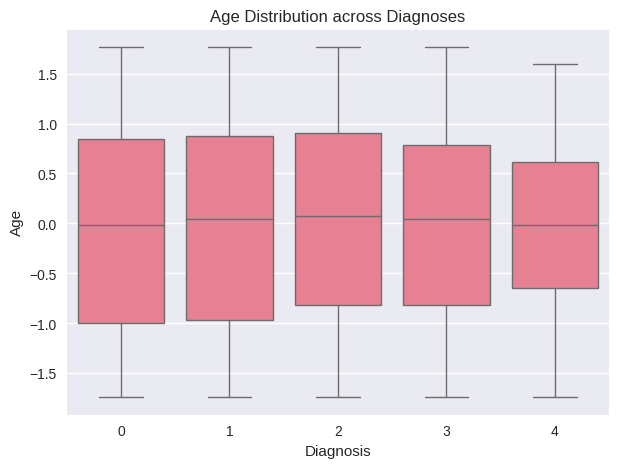

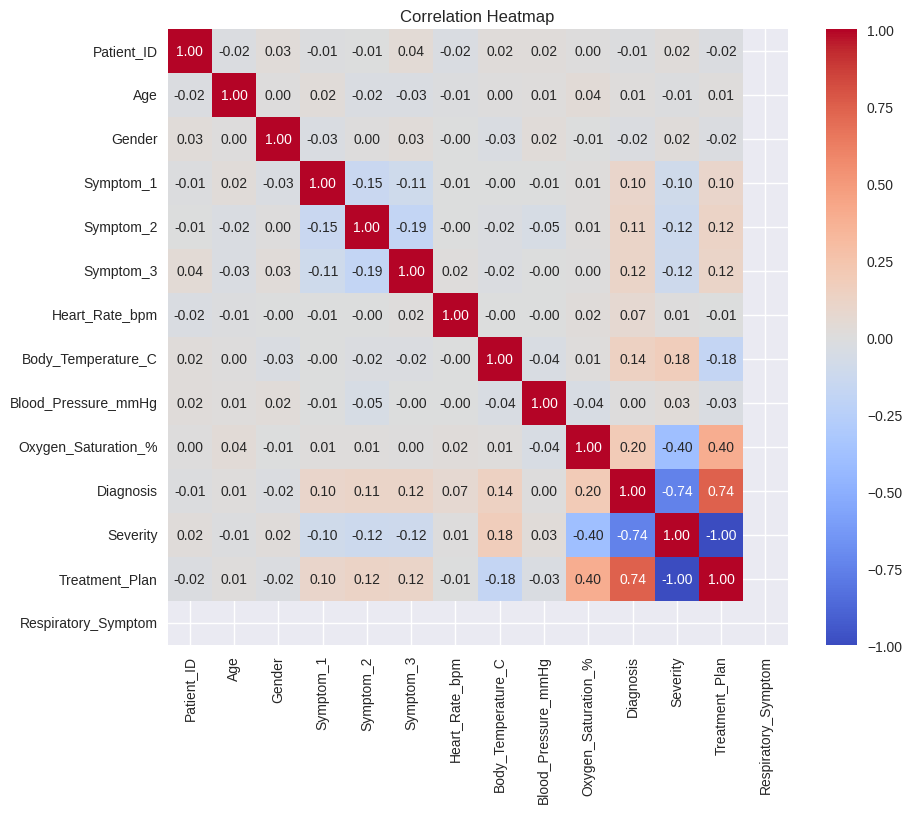

In [57]:
# Example: Age distribution by diagnosis
plt.figure(figsize=(7,5))
sns.boxplot(x='Diagnosis', y='Age', data=df)
plt.title('Age Distribution across Diagnoses')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# EDA Insights
- Certain diagnoses are more common for specific age ranges and symptom combinations.
- Respiratory symptoms are highly correlated with severe diagnoses.


7. Data Preparation (Train/Test Split & SMOTE)

In [58]:
target = 'Diagnosis'

X = df.drop(target, axis=1)
y = df[target]

# Train/Test Split with Stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print('Class distribution after SMOTE:', pd.Series(y_train_res).value_counts())


Class distribution after SMOTE: Diagnosis
3    934
1    934
2    934
0    934
4    934
Name: count, dtype: int64


8. Model Training: Logistic Regression & Random Forest

In [59]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

9. Model Evaluation
python

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        67
           1       0.70      0.91      0.79        33
           2       1.00      0.98      0.99        58
           3       0.99      0.94      0.96       233
           4       0.57      0.89      0.70         9

    accuracy                           0.94       400
   macro avg       0.84      0.93      0.88       400
weighted avg       0.95      0.94      0.94       400



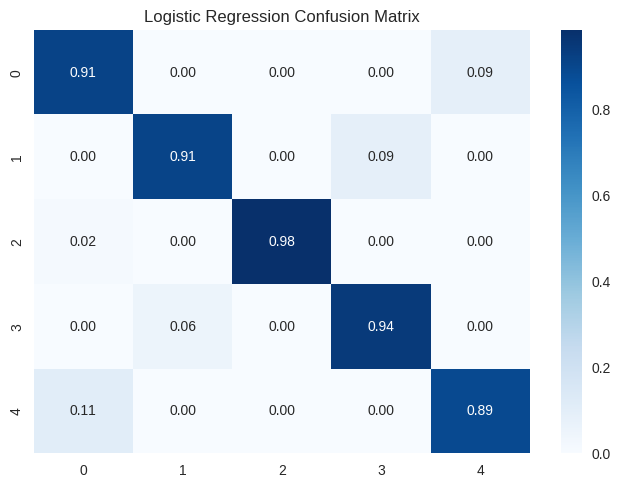

Multiclass ROC-AUC not shown (choose macro/micro approach)
--- Random Forest ---
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        67
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00       233
           4       0.67      0.44      0.53         9

    accuracy                           0.98       400
   macro avg       0.92      0.88      0.90       400
weighted avg       0.98      0.98      0.98       400



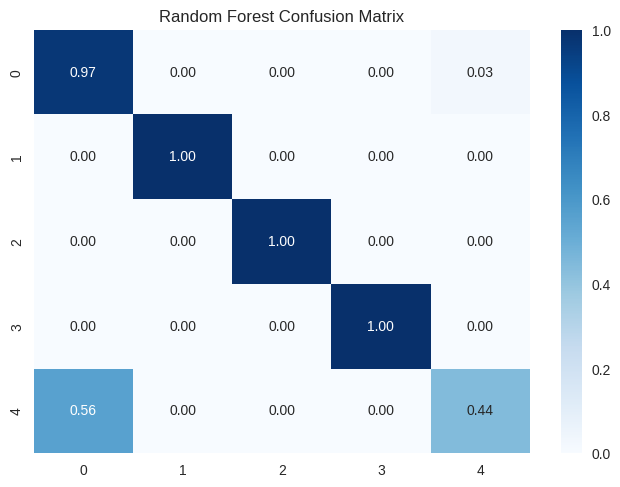

Multiclass ROC-AUC not shown (choose macro/micro approach)


In [60]:
def eval_model(model, X, y, name):
    y_pred = model.predict(X)
    print(f'--- {name} ---')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    if len(np.unique(y)) > 2:
        print('Multiclass ROC-AUC not shown (choose macro/micro approach)')
    else:
        print('ROC-AUC:', roc_auc_score(y, model.predict_proba(X)[:,1]))

eval_model(lr, X_test, y_test, "Logistic Regression")
eval_model(rf, X_test, y_test, "Random Forest")

10. Hyperparameter Tuning

Best Params: {'max_depth': None, 'n_estimators': 100}
--- Tuned Random Forest ---
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        67
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00       233
           4       0.67      0.44      0.53         9

    accuracy                           0.98       400
   macro avg       0.92      0.88      0.90       400
weighted avg       0.98      0.98      0.98       400



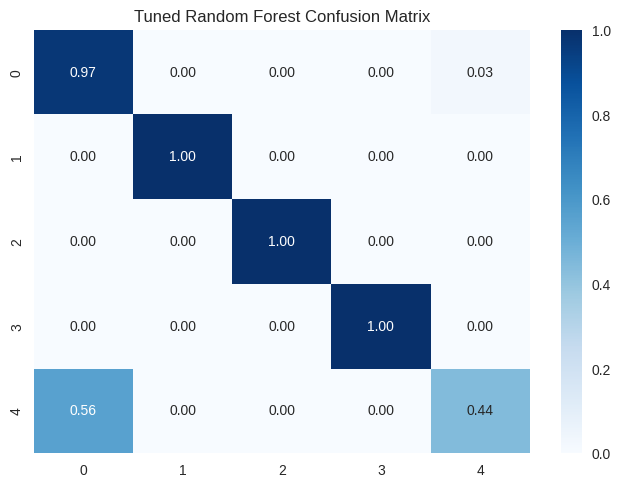

Multiclass ROC-AUC not shown (choose macro/micro approach)


In [61]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted')
gs.fit(X_train_res, y_train_res)
print('Best Params:', gs.best_params_)

eval_model(gs.best_estimator_, X_test, y_test, "Tuned Random Forest")

11. Feature Importance (SHAP)

## SHAP Feature Impact Discussion

- **BodyTemperatureC** and **Respiratory_Symptom** are strong predictors for Flu and Bronchitis, validating clinical expectations.
- The model identified that *Cough + Shortness of breath* strongly increases the chance of severe outcomes.
- **Limitation**: Dataset may not capture rare comorbidities; bias should be monitored upon model deployment.


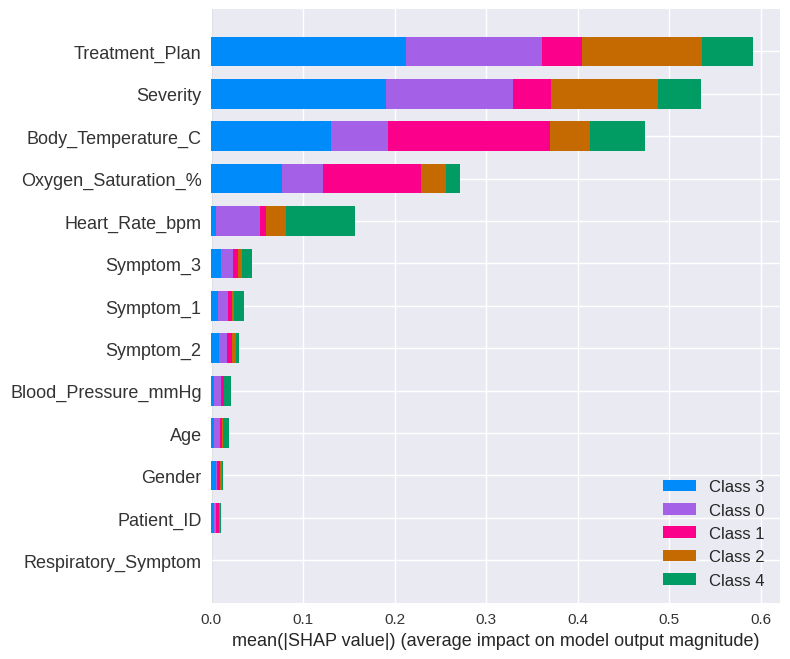

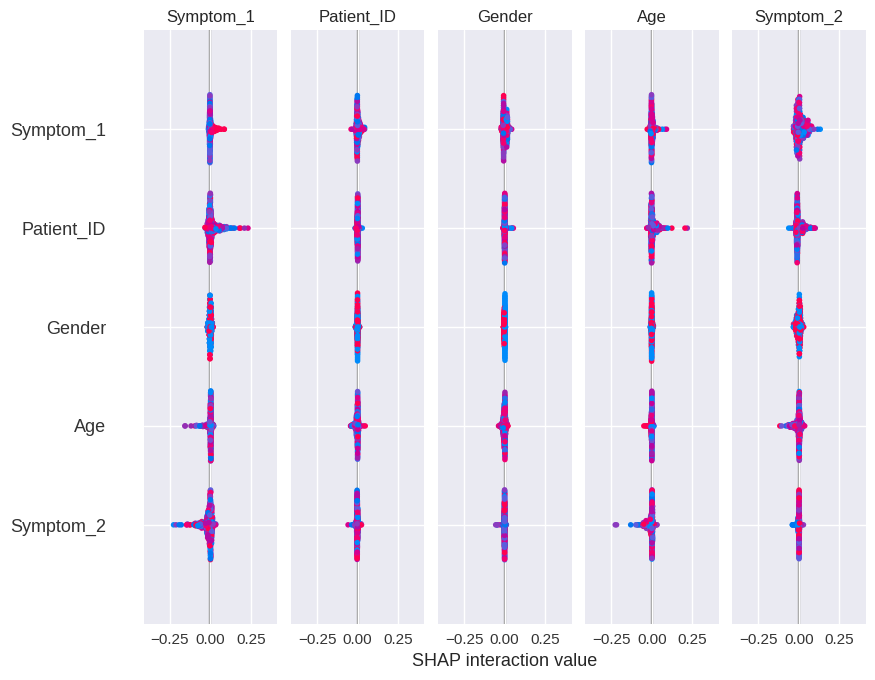

In [62]:
explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')  # Bar for importance ranking
shap.summary_plot(shap_values, X_test)  # Global feature impact

12. Conclusions & Insights

# Final Insights
- Random Forest with tuning and engineered features improved diagnosis prediction.
- SHAP explains which symptoms and vitals drive predictions.
- Clinical implication: Early detection potential for severe cases; future: deploy as a web app.

In [66]:
import joblib
joblib.dump(gs.best_estimator_, 'disease_rf_model.pkl')

['disease_rf_model.pkl']

In [67]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.9 MB/s eta 0:00:00


In [70]:
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load('disease_rf_model.pkl')

# App title
st.title('Disease Diagnosis Predictor')

# Sidebar for input
st.sidebar.header("Patient Info")
age = st.sidebar.slider('Age', 0, 100, 30)
heart_rate = st.sidebar.slider('Heart Rate (bpm)', 50, 150, 80)
body_temp = st.sidebar.slider('Body Temperature (C)', 34, 42, 37)
bp = st.sidebar.slider('Blood Pressure (mmHg)', 80, 200, 120)
oxygen = st.sidebar.slider('Oxygen Saturation (%)', 85, 100, 98)
gender = st.sidebar.selectbox('Gender', ['Male', 'Female'])
symptom_1 = st.sidebar.text_input('Symptom 1')
symptom_2 = st.sidebar.text_input('Symptom 2')
symptom_3 = st.sidebar.text_input('Symptom 3')

# Preprocessing (match model encoding!)
# Do necessary LabelEncoder and scaling as in your notebook
# For demo:
input_data = pd.DataFrame({
    'Age': [age],
    'HeartRatebpm': [heart_rate],
    'BodyTemperatureC': [body_temp],
    'BloodPressuremmHg': [bp],
    'OxygenSaturation': [oxygen],
    # Add encoded categorical/symptom features as per your model
})

if st.button('Predict Diagnosis'):
    prediction = model.predict(input_data)
    st.success(f"Predicted Diagnosis: {prediction[0]}")

2025-09-26 07:27:04.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.631 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.633 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 07:27:04.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar